In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import uproot
import awkward as ak
import tabulate as tab
# !pip install "uproot[http]"
# !pip install awkward-pandas
# pip install pyarrow (for ak.to_parquet)
# !pip install tabulate

In [2]:
def get_info(akw, display=False):
    # akw['waveformsADC'][trigRec][chID]
    Nevents    = len(akw['waveformsADC'])
    TrigWindow = len(akw['waveformsADC'][0][0])
    Nchannels  = len(akw['waveformsADC'][0])
    maxima = []
    for chID in range(0, Nchannels):
        maxima.append(ak.max( akw['waveformsADC'][:][chID]) )
    if display:
        print(' events', Nevents)
        print(' trigger window', TrigWindow)
        print(' number of channels', Nchannels)
        print(' max height', int(np.max(maxima)) )
    return Nevents, TrigWindow, Nchannels, maxima

In [3]:
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data'

In [4]:
filepath = f'{cernbox}/anaCRP_files'
with open(f"{filepath}/pns_pedSub.pkl", "rb") as f:
    pns = pickle.load(f)
with open(f"{filepath}/cos_pedSub.pkl", "rb") as f:
    cos = pickle.load(f)
pns.keys()

dict_keys(['waveformsADC', 'waveformsSubtracted', 'pedestals'])

In [5]:
print('PNS')
_, _, _, _ = get_info(pns, display=True)
print('Cosmics')
_, _, _, _ = get_info(cos, display=True)

PNS
 events 2324
 trigger window 65600
 number of channels 12
 max height 16383
Cosmics
 events 588
 trigger window 262208
 number of channels 12
 max height 16383


## Waveforms

In [6]:
def plot_One_event(akw, evtID, plot_title="", y = 'waveformsADC'):
    fig, axs = plt.subplots(3, 4, figsize=(16, 10))
    fig.suptitle(f'{plot_title} evt {evtID}', fontsize=16)
    
    _, TrigWindow, Nchannels, _ = get_info(akw, False)

    x = np.arange(0,TrigWindow, 1)

    a = 0
    for chID in range(0, Nchannels):
        ax = axs.flatten()[a]
        ax.plot(x, akw[y][evtID, chID]);
        a+=1
        ax.set_xlabel('time ticks')
        ax.set_ylabel(y)
        ax.set_title(f'chID{chID}', x=0.2,  y = 0.85)
    

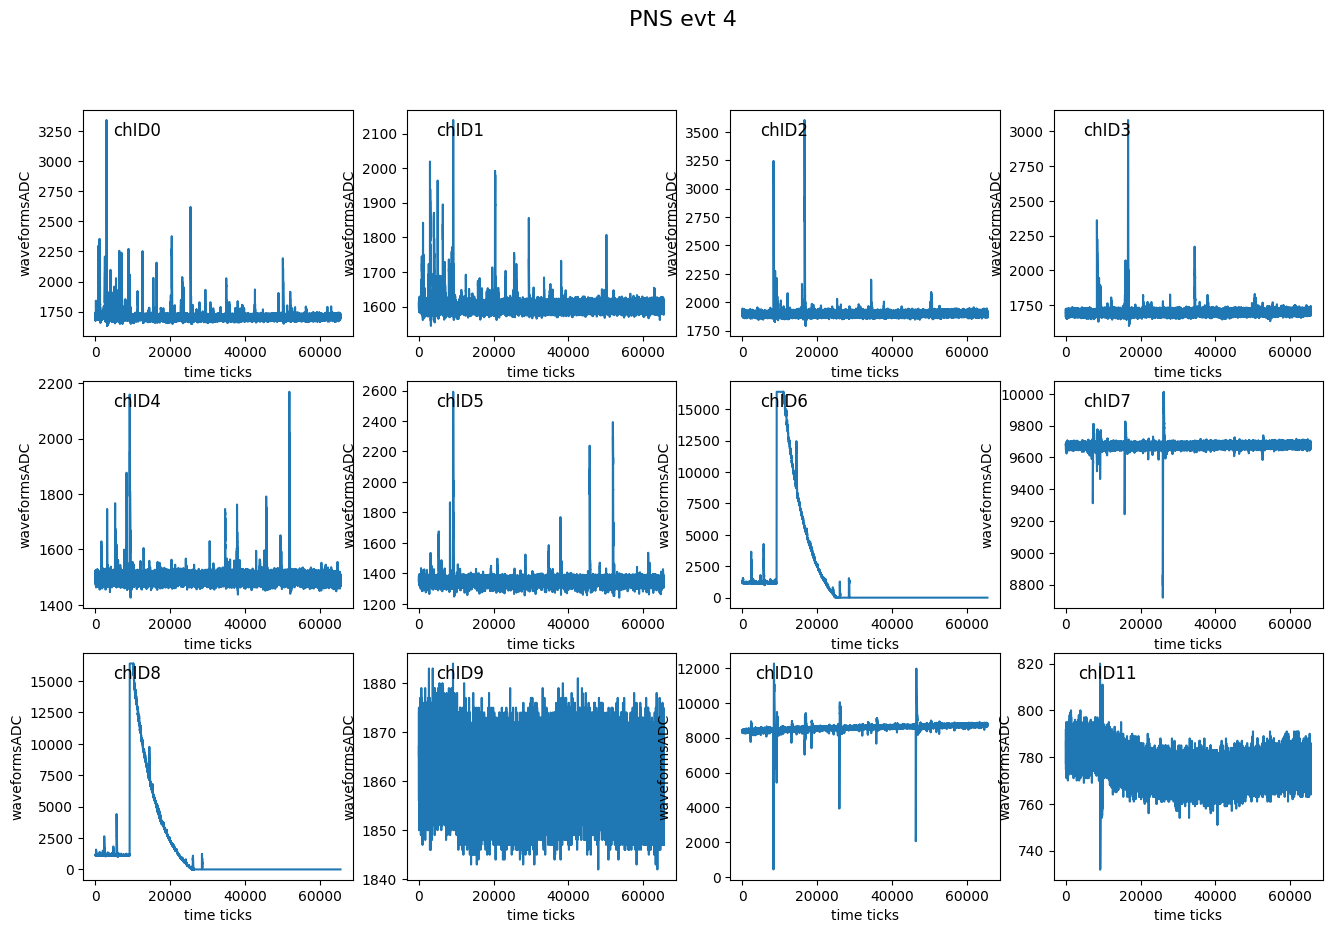

In [7]:
plot_One_event(pns, evtID=4, plot_title="PNS")

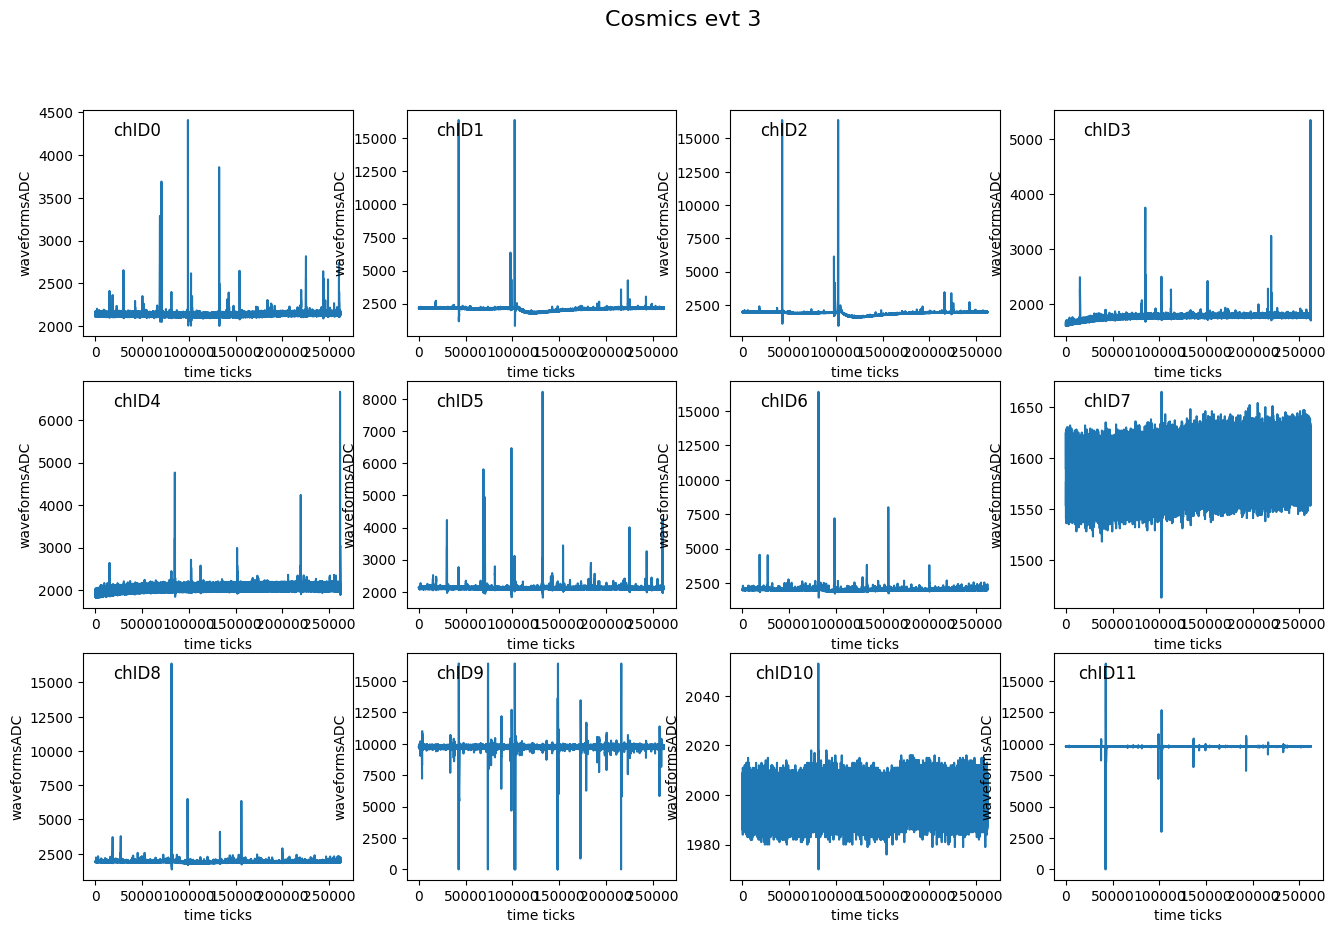

In [8]:
plot_One_event(cos, evtID=3, plot_title="Cosmics")


# Pedestal Subtraction

### Sanity check

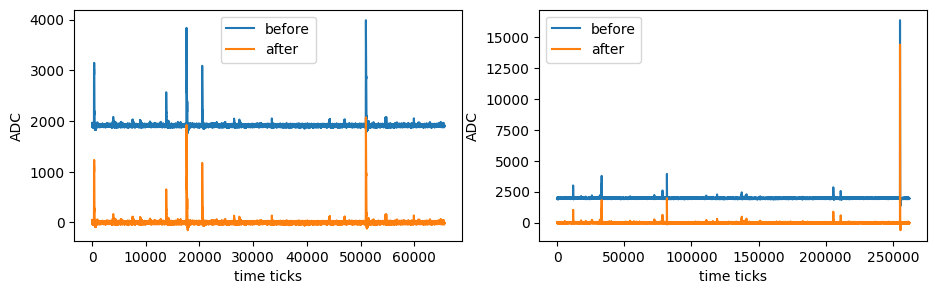

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))
idx, chID = 342, 2
axs[0].plot(pns['waveformsADC'][idx, chID], label='before')
axs[0].plot(pns["waveformsSubtracted"][idx, chID], label='after')
axs[0].set_xlabel('time ticks')
axs[0].set_ylabel('ADC')
axs[0].legend(loc='upper center')
axs[1].plot(cos['waveformsADC'][idx, chID], label='before')
axs[1].plot(cos["waveformsSubtracted"][idx, chID], label='after')
axs[1].set_xlabel('time ticks')
axs[1].set_ylabel('ADC')
axs[1].legend()


## TODO: Baseline Stability

In [10]:
## some TrigRec have not linear baseline
# -> identify these events and make a decision
# one channel in particular?
# few events -> remove them

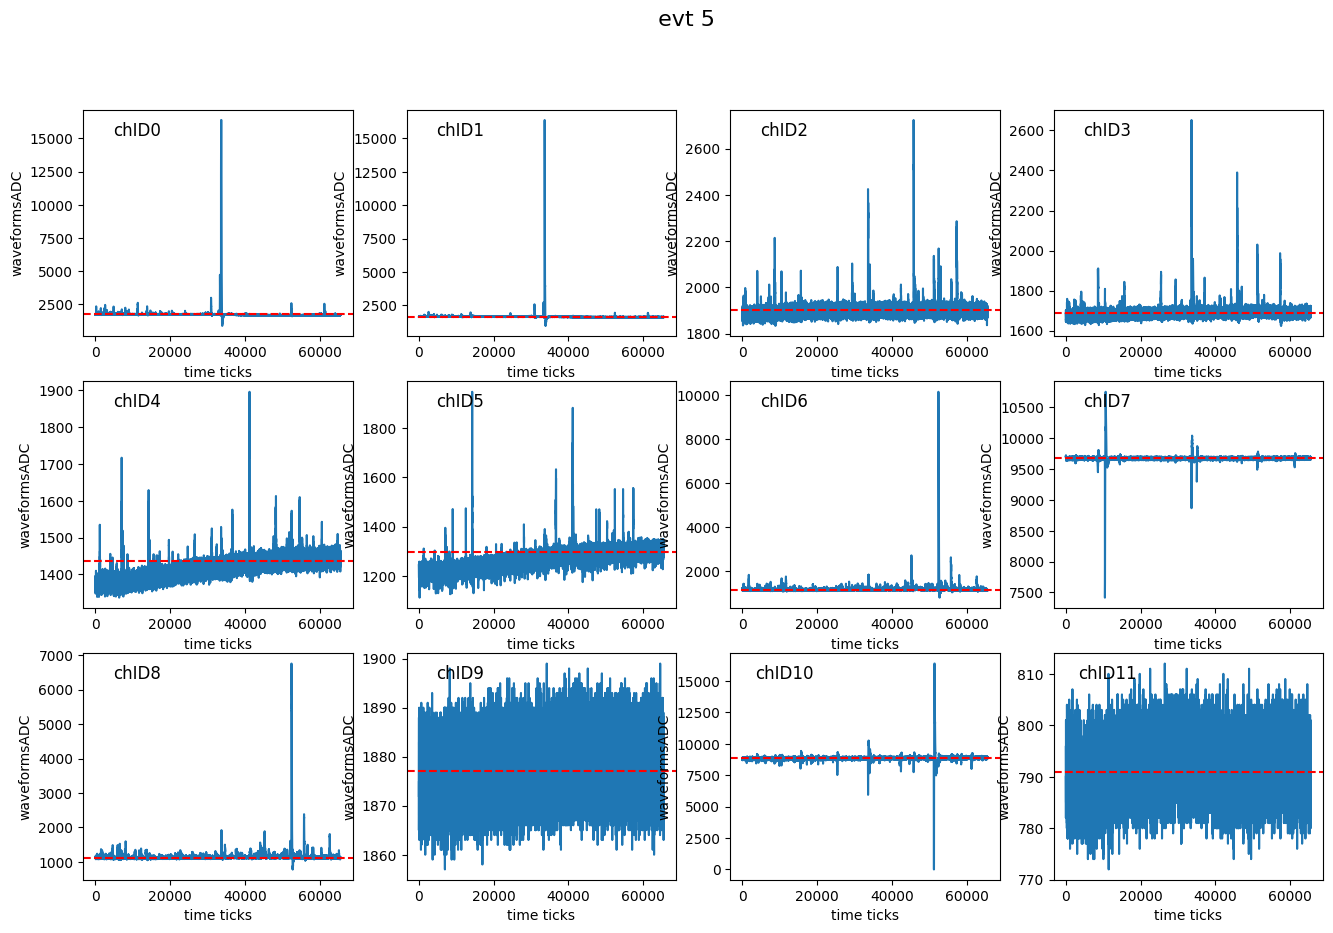

In [11]:
def plot_stuff(akw, evtID, plot_title="", y = 'waveformsADC'):
    fig, axs = plt.subplots(3, 4, figsize=(16, 10))
    fig.suptitle(f'{plot_title} evt {evtID}', fontsize=16)
    
    _, TrigWindow, Nchannels, _ = get_info(akw, False)

    x = np.arange(0,TrigWindow, 1)

    a = 0
    for chID in range(0, Nchannels):
        ax = axs.flatten()[a]
        ax.plot(x, akw[y][evtID, chID]);
        ax.axhline(y=akw['pedestals'][evtID, chID], color='red', linestyle='--')
        a+=1
        ax.set_xlabel('time ticks')
        ax.set_ylabel(y)
        ax.set_title(f'chID{chID}', x=0.2,  y = 0.85)
        # ax.set_ylim(1000, 2500)

plot_stuff(pns, 5, plot_title="",  y = 'waveformsADC') # waveformsSubtracted

In [12]:
def estimate_robust_baseline(waveform, max_deviation=5):
    median = np.median(waveform)
    mad    = np.median(np.abs(waveform - median))  # deviation from median

    # Keep only "quiet" points near the median
    quiet = np.abs(waveform - median) < max_deviation * mad
    baseline = np.mean(waveform[quiet])
    rms = np.std(waveform[quiet])
    return baseline, rms, quiet

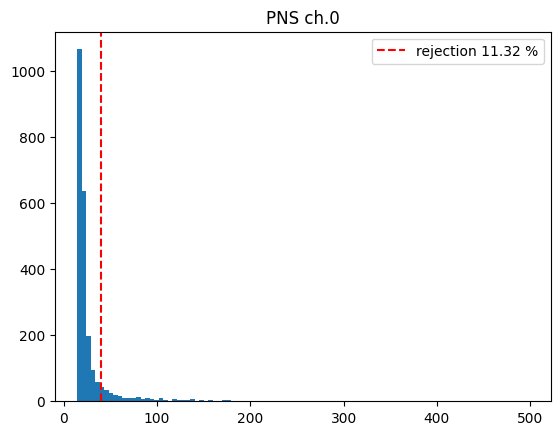

In [13]:
chID = 0
rmses = []
Nevents, TrigWindow, Nchannels, _ = get_info(pns, display=False)
for evt in range(0, Nevents):
    baseline, rms, quiet = estimate_robust_baseline(pns['waveformsADC'][evt, chID], max_deviation=5)
    rmses.append(rms)
rmses = np.array(rmses)
plt.hist(rmses, bins=100);
eff = rmses[rmses>40].shape[0]/Nevents
plt.title(f'PNS ch.{chID}')
plt.axvline(x=40, color='red', linestyle='--', label=f'rejection {eff*100:.2f} %')
plt.legend();

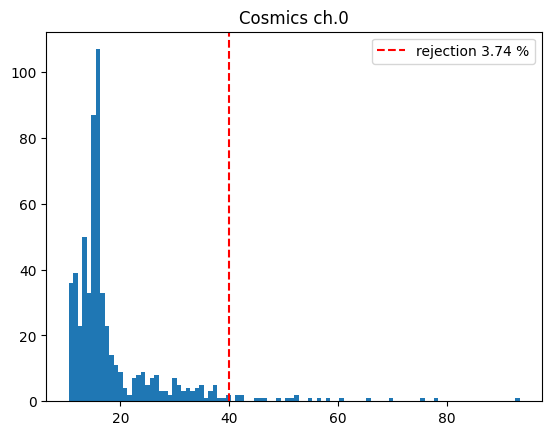

In [14]:
chID = 0
rmses = []
Nevents, TrigWindow, Nchannels, _ = get_info(cos, display=False)
for evt in range(0, Nevents):
    baseline, rms, quiet = estimate_robust_baseline(cos['waveformsADC'][evt, chID], max_deviation=5)
    rmses.append(rms)
rmses = np.array(rmses)
plt.hist(rmses, bins=100);
eff = rmses[rmses>40].shape[0]/Nevents
plt.title(f'Cosmics ch.{chID}')
plt.axvline(x=40, color='red', linestyle='--', label=f'rejection {eff*100:.2f} %')
plt.legend();

In [15]:
# rmses

52.49571459042552


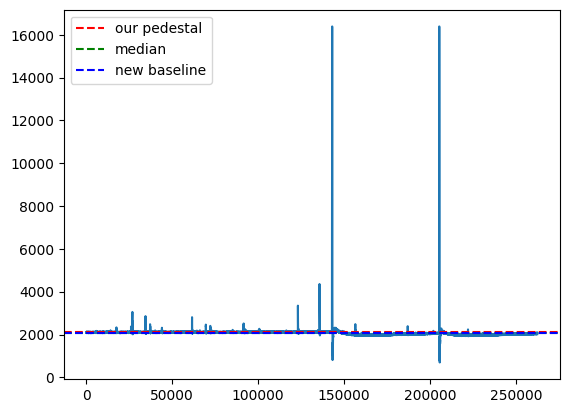

In [16]:
evt, chID = 62, 0
waveform = cos['waveformsADC'][evt, chID ]
median = np.median(waveform)
# print(median)

baseline, rms, quiet = estimate_robust_baseline(cos['waveformsADC'][evt, chID], max_deviation=5)
print(rms)

_, TrigWindow, _, _ = get_info(cos, False)
x = np.arange(0,TrigWindow, 1)
plt.plot(x, waveform);
plt.axhline(y=cos['pedestals'][evt, chID], color='red', linestyle='--', label='our pedestal')
plt.axhline(y=median, color='green', linestyle='--', label='median')
plt.axhline(y=baseline, color='blue', linestyle='--', label='new baseline')
plt.legend();

In [17]:
cut = 40
Nevents_pns, _, _, _ = get_info(pns, display=False)
Nevents_cos, _, _, _ = get_info(cos, display=False)
rej_pns, rej_cos = [], []
rms_pns_ar, rms_cos_ar = [], []
for chID in range(0, 12):
    rms_pns = np.array([estimate_robust_baseline(pns['waveformsADC'][evt, chID], max_deviation=5)[1] for evt in range(0, Nevents_pns)])
    rms_pns_ar.append(rms_pns)
    rej_pns.append(rms_pns[rms_pns>40].shape[0]*100/Nevents_pns)
    rms_cos = np.array([estimate_robust_baseline(cos['waveformsADC'][evt, chID], max_deviation=5)[1] for evt in range(0, Nevents_cos)])
    rms_cos_ar.append(rms_cos)
    rej_cos.append(rms_cos[rms_cos>40].shape[0]*100/Nevents_cos)    
rms_pns_ar = np.array(rms_pns_ar)
rms_cos_ar = np.array(rms_cos_ar)

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
lines = [['channel', 'PNS rejection [%]', 'Cosmics rejection [%]']]
for chID in range(len(rej_pns)):
    lines.append( [chID, f'{rej_pns[chID]:.1f}', f'{rej_cos[chID]:.1f}'] )
print(tab.tabulate(lines, headers="firstrow", tablefmt="github"))

|   channel |   PNS rejection [%] |   Cosmics rejection [%] |
|-----------|---------------------|-------------------------|
|         0 |                11.3 |                     3.7 |
|         1 |                 3   |                    13.3 |
|         2 |                 8   |                    15.8 |
|         3 |                 7.9 |                     4.9 |
|         4 |                 7.3 |                    50.5 |
|         5 |                 9.3 |                    16   |
|         6 |                87.9 |                    48.8 |
|         7 |                 0   |                     0   |
|         8 |                35.1 |                    37.1 |
|         9 |                 0   |                   100   |
|        10 |               100   |                     0   |
|        11 |                 0   |                     0   |


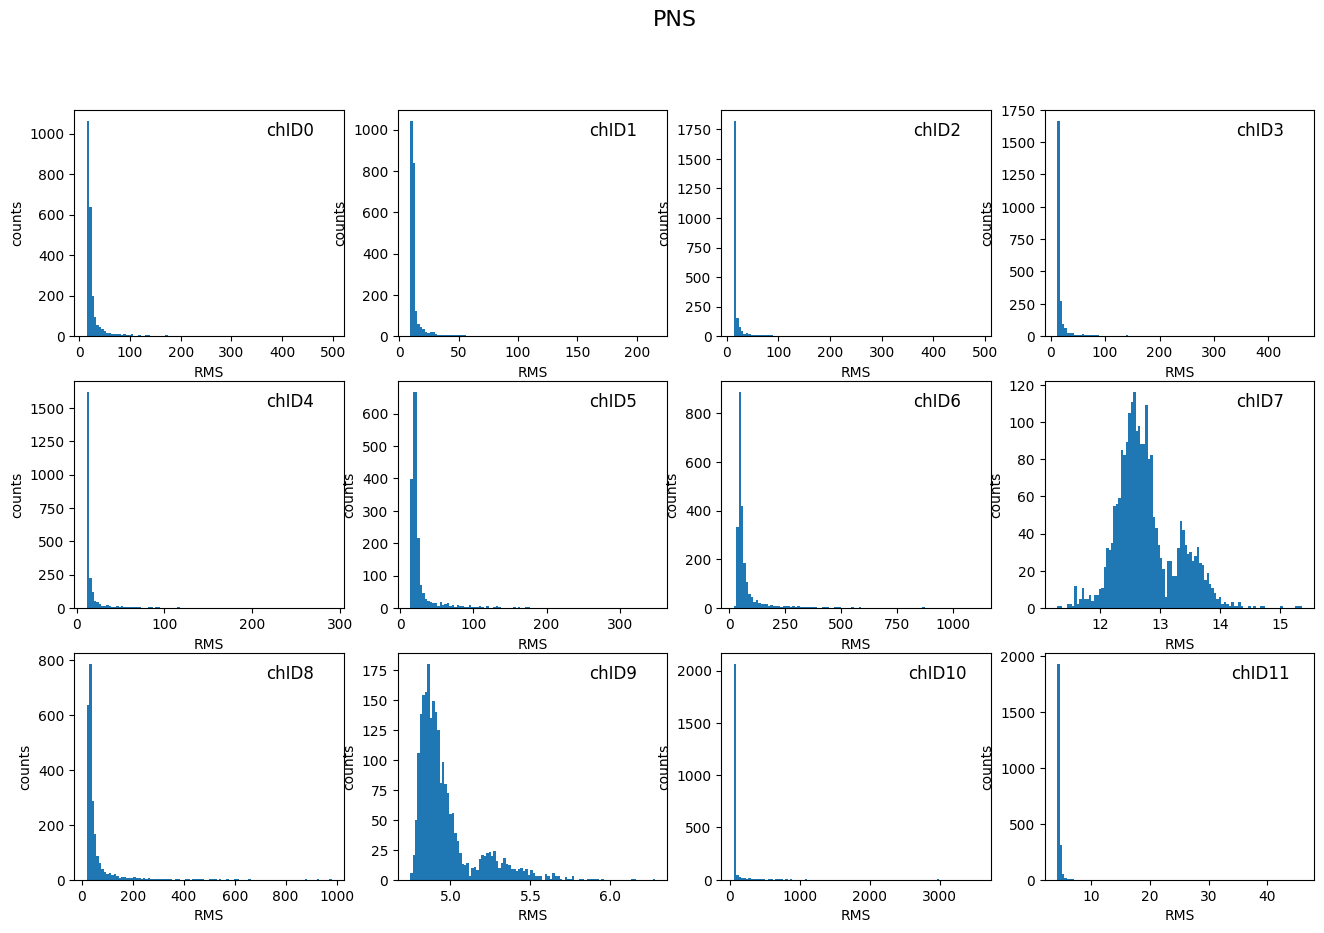

In [19]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle(f'PNS', fontsize=16)

a = 0
for chID in range(0, 12):
    ax = axs.flatten()[a]
    ax.hist(rms_pns_ar[chID], bins=100)
    # ax.axvline(x=cut, color='red', linestyle='--', label='threshold')
    a+=1
    ax.set_xlabel('RMS')
    ax.set_ylabel('counts')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
    # ax.set_ylim(1000, 2500)

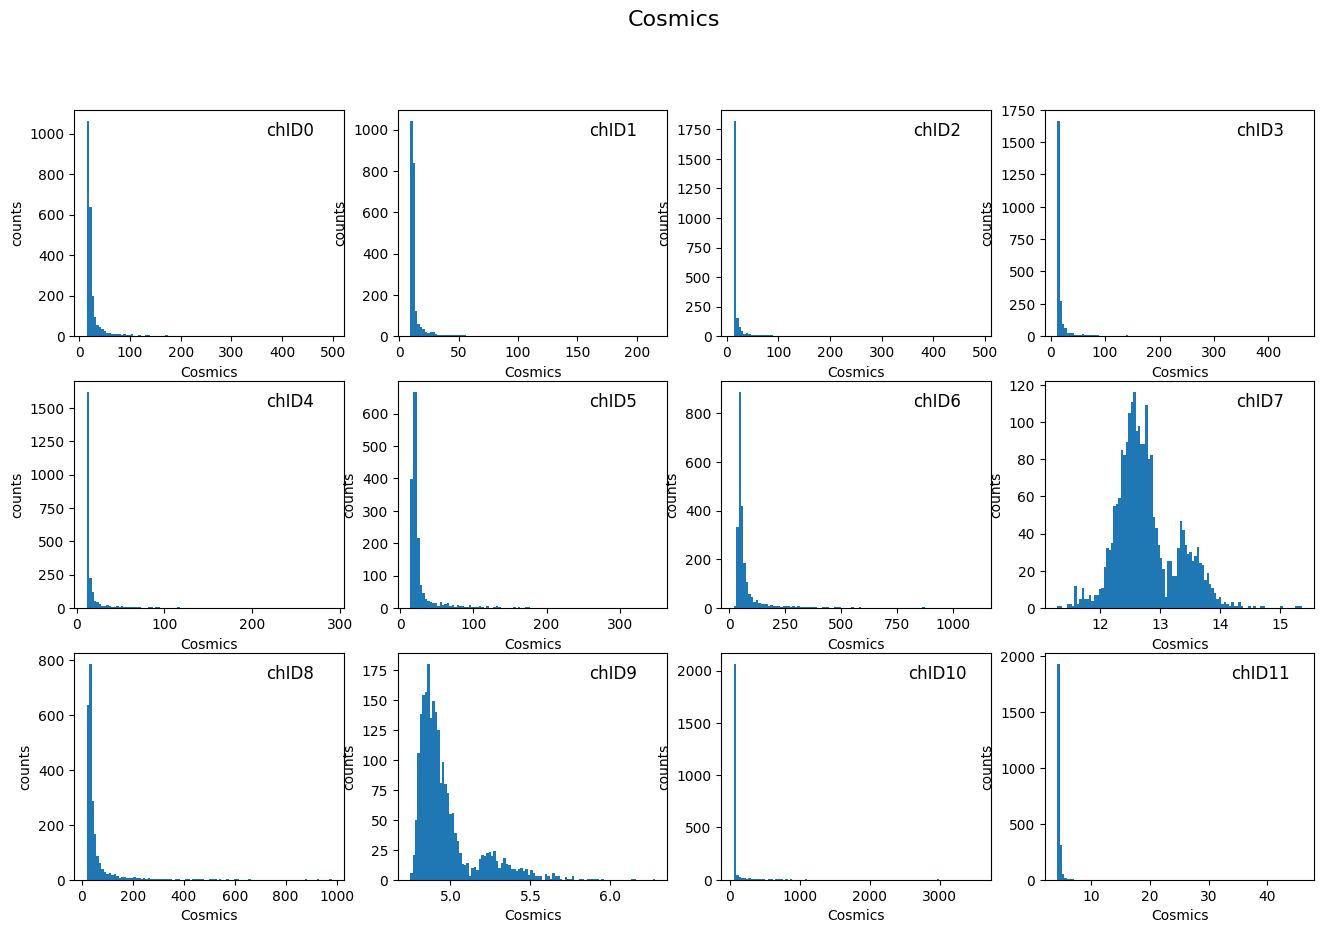

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle(f'Cosmics', fontsize=16)

a = 0
for chID in range(0, 12):
    ax = axs.flatten()[a]
    ax.hist(rms_pns_ar[chID], bins=100)
    # ax.axvline(x=cut, color='red', linestyle='--', label='threshold')
    a+=1
    ax.set_xlabel('Cosmics')
    ax.set_ylabel('counts')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
    # ax.set_ylim(1000, 2500)

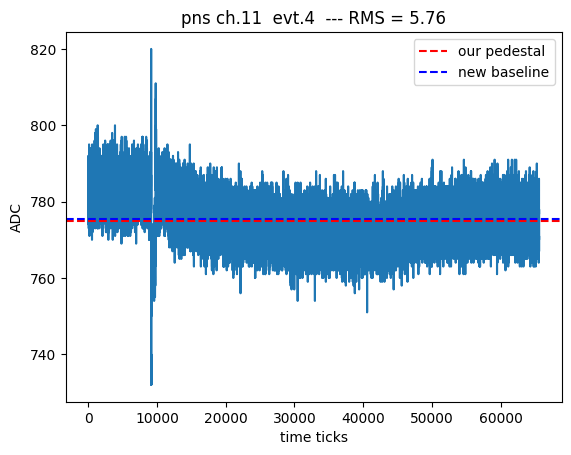

In [21]:
evt, chID, sample = 4, 11, 'pns'

spl = pns if sample=='pns' else cos
waveform = spl['waveformsADC'][evt, chID ]
median = np.median(waveform)

baseline, rms, quiet = estimate_robust_baseline(waveform, max_deviation=5)

_, TrigWindow, _, _ = get_info(spl, False)
x = np.arange(0,TrigWindow, 1)
plt.plot(x, waveform);
plt.axhline(y=spl['pedestals'][evt, chID], color='red', linestyle='--', label='our pedestal')
# plt.axhline(y=median, color='green', linestyle='--', label='median')
plt.axhline(y=baseline, color='blue', linestyle='--', label='new baseline')
plt.title(f'{sample} ch.{chID}  evt.{evt}  --- RMS = {rms:.2f}')
plt.xlabel('time ticks')
plt.ylabel('ADC')
plt.legend();

In [22]:
def plot_Event_wRMS(akw, evtID, sample='pns'):
    akw = pns if sample=='pns' else cos

    fig, axs = plt.subplots(3, 4, figsize=(20, 14))
    fig.suptitle(f'{sample} evt {evtID}', fontsize=16)

    
    _, TrigWindow, Nchannels, _ = get_info(akw, False)
    x = np.arange(0,TrigWindow, 1)

    a = 0
    for chID in range(0, Nchannels):
        ax = axs.flatten()[a]
        waveform = akw['waveformsADC'][evt, chID ]
        baseline, rms, quiet = estimate_robust_baseline(waveform, max_deviation=5)
        ax.plot(x, waveform);
        ax.axhline(y=akw['pedestals'][evt, chID], color='red', linestyle='--', label='our pedestal')
        ax.axhline(y=baseline, color='blue', linestyle='--', label='new baseline')
        a+=1
        ax.set_xlabel('time ticks')
        ax.set_ylabel('ADC')
        ax.set_title(f'{sample} ch.{chID}  evt.{evt}  --- RMS = {rms:.2f}')
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))